# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

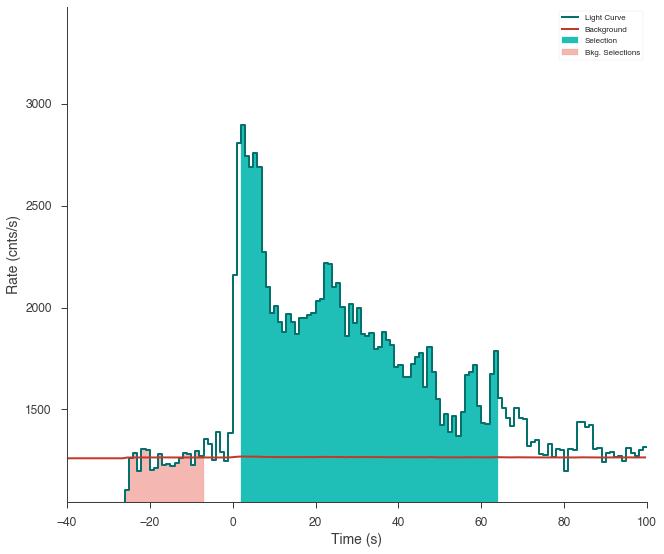

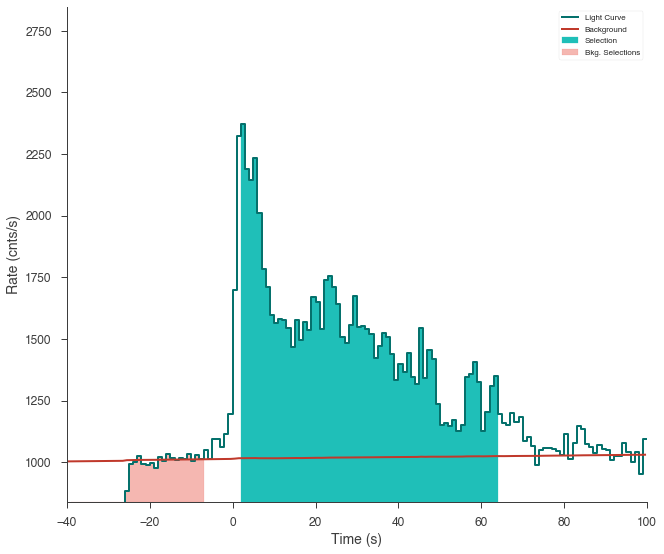

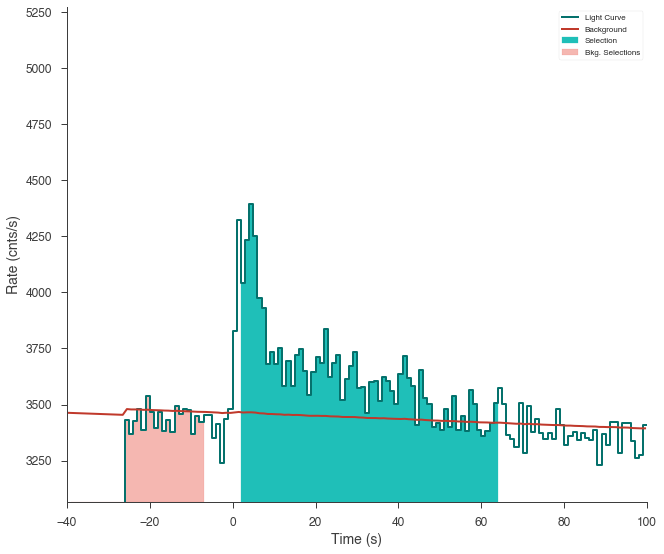

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

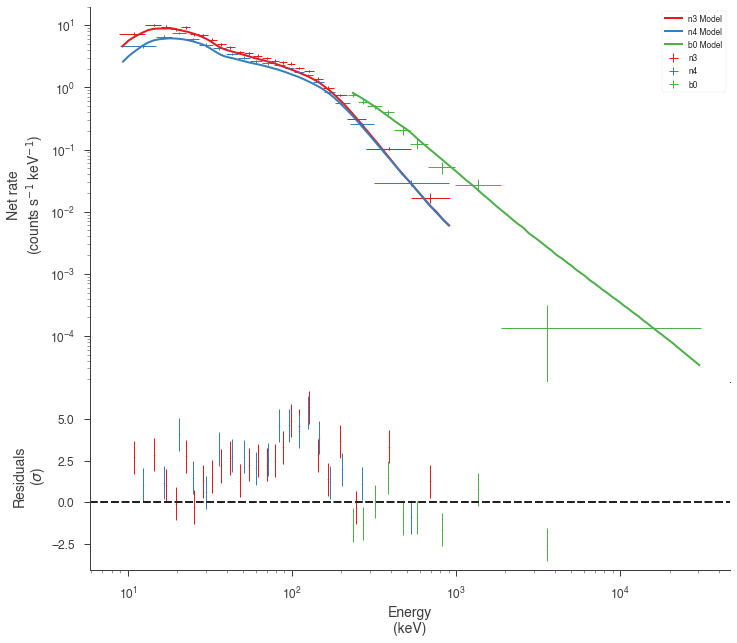

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                              
GRB080916009...K             (1.469 +/- 0.018) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                  -1.071 +/- 0.016                 
GRB080916009...break_energy     (2.29 +/- 0.28) x 10^2              keV
GRB080916009...break_scale       (2.3 +/- 0.7) x 10^-1                 
GRB080916009...beta                     -2.17 +/- 0.10


Values of -log(posterior) at the minimum:



-log(posterior)
b0        -1051.924240
n3        -1022.821529
n4        -1014.764673
total     -3089.510442


Values of statistical measures:



statistical measures
AIC              6189.191338
BIC              6208.423549
DIC              6175.689990
PDIC                4.234099
log(Z)          -1347.819442

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************
 ln(ev)=  -3103.4689560113184      +/-  0.22715119873622353     
 Total Likelihood Evaluations:        21239
 Sampling finished. Exiting MultiNest


Now our model seems to match much better with the data!

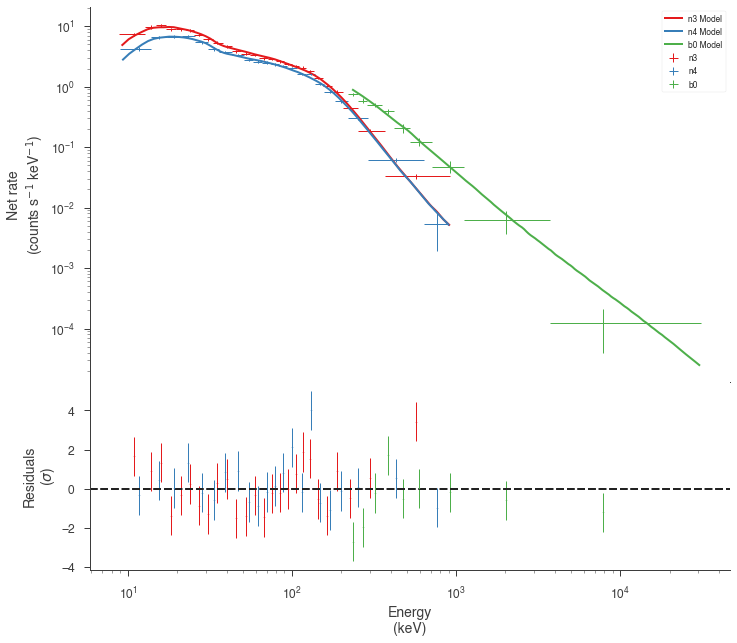

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid ** 2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

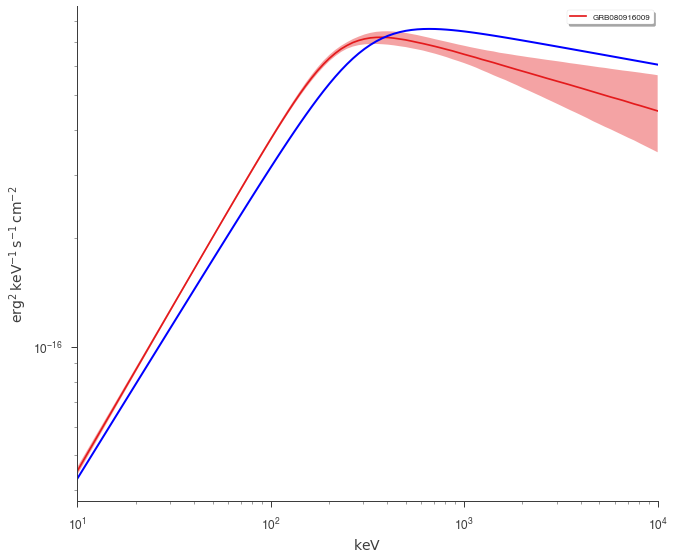

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


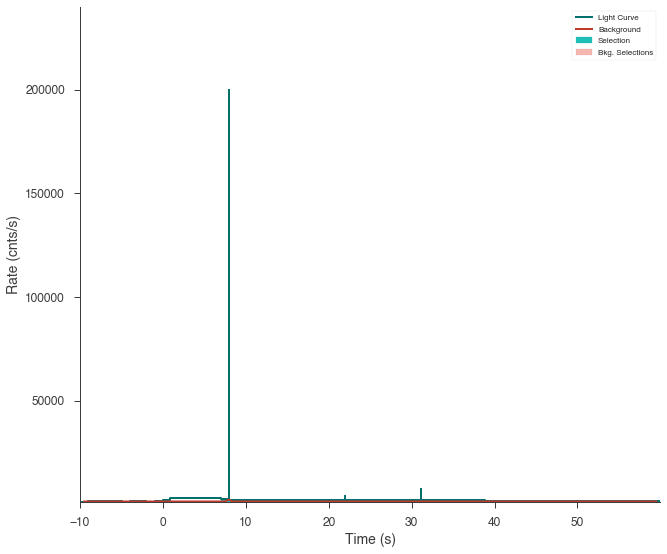

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

Now our light curve looks much more acceptable.

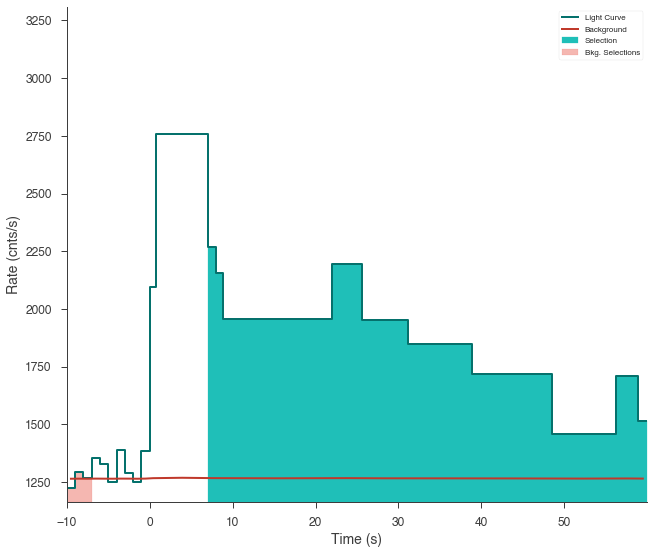

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                            
grb.spectrum.main.Band.K       (3.9 +/- 0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.0 +/- 1.2) x 10^-1                 
grb.spectrum.main.Band.xp       (2.9 +/- 0.4) x 10^2              keV
grb.spectrum.main.Band.beta        -2.08 -0.13 +0.14


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval0      -280.493121
n3_interval0      -244.964992
n4_interval0      -261.493620
total             -786.951733


Values of statistical measures:



statistical measures
AIC              1582.016781
BIC              1597.425598
DIC              1560.813916
PDIC                2.470273
log(Z)           -343.413953

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                              
grb.spectrum.main.Band.K       (4.14 +/- 0.14) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.53 +/- 0.28) x 10^-1                 
grb.spectrum.main.Band.xp         (6.1 +/- 0.5) x 10^2              keV
grb.spectrum.main.Band.beta          -2.23 -0.10 +0.11


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval1      -665.659259
n3_interval1      -634.252694
n4_interval1      -638.005235
total            -1937.917188


Values of statistical measures:



statistical measures
AIC              3883.947690
BIC              3899.356507
DIC              3858.881318
PDIC                3.703017
log(Z)           -843.758846

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                               
grb.spectrum.main.Band.K      (3.65 -0.4 +0.35) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.2 -1.1 +0.9) x 10^-1                 
grb.spectrum.main.Band.xp        (2.6 -0.4 +0.5) x 10^2              keV
grb.spectrum.main.Band.beta           -1.86 -0.04 +0.05


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval2      -321.515457
n3_interval2      -285.754246
n4_interval2      -304.474583
total             -911.744286


Values of statistical measures:



statistical measures
AIC              1831.601887
BIC              1847.010704
DIC              1814.900853
PDIC                1.426862
log(Z)           -400.002185

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                               
grb.spectrum.main.Band.K      (3.19 -0.4 +0.34) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-8.6 +/- 0.7) x 10^-1                 
grb.spectrum.main.Band.xp        (3.0 -0.5 +0.4) x 10^2              keV
grb.spectrum.main.Band.beta           -2.18 -0.11 +0.09


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval3      -291.850564
n3_interval3      -237.069891
n4_interval3      -257.191713
total             -786.112168


Values of statistical measures:



statistical measures
AIC              1580.337651
BIC              1595.746468
DIC              1559.334141
PDIC                2.353009
log(Z)           -343.417276

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                 
grb.spectrum.main.Band.K       (3.09 -0.04 +0.05) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.49 -0.17 +0.16) x 10^-1                 
grb.spectrum.main.Band.xp          (2.12 +/- 0.04) x 10^2              keV
grb.spectrum.main.Band.beta          -1.844 -0.026 +0.028


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval4      -774.236755
n3_interval4      -761.230680
n4_interval4      -743.550620
total            -2279.018056


Values of statistical measures:



statistical measures
AIC              4566.149426
BIC              4581.558243
DIC              4547.551455
PDIC                1.145326
log(Z)           -994.970066

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.82 -0.19 +0.18) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha      (-9.0 +/- 0.5) x 10^-1                 
grb.spectrum.main.Band.xp           (4.2 +/- 0.5) x 10^2              keV
grb.spectrum.main.Band.beta               -2.30 +/- 0.21


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval5      -531.948218
n3_interval5      -517.879888
n4_interval5      -522.433648
total            -1572.261754


Values of statistical measures:



statistical measures
AIC              3152.636822
BIC              3168.045640
DIC              3130.843189
PDIC                3.309785
log(Z)           -684.771993

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.09 -0.11 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha      (-9.6 +/- 0.4) x 10^-1                 
grb.spectrum.main.Band.xp           (3.9 +/- 0.4) x 10^2              keV
grb.spectrum.main.Band.beta            -2.43 -0.22 +0.23


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval6      -607.066728
n3_interval6      -577.803350
n4_interval6      -570.883431
total            -1755.753509


Values of statistical measures:



statistical measures
AIC              3519.620333
BIC              3535.029151
DIC              3497.853027
PDIC                3.144397
log(Z)           -764.857982

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.64 -0.07 +0.06) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha            -1.056 +/- 0.029                 
grb.spectrum.main.Band.xp           (4.4 +/- 0.4) x 10^2              keV
grb.spectrum.main.Band.beta            -2.43 -0.20 +0.23


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval7      -659.247248
n3_interval7      -635.205898
n4_interval7      -644.259416
total            -1938.712562


Values of statistical measures:



statistical measures
AIC              3885.538439
BIC              3900.947257
DIC              3862.530553
PDIC                2.600817
log(Z)           -844.637706

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.58 -0.13 +0.12) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha      (-8.2 +/- 0.6) x 10^-1                 
grb.spectrum.main.Band.xp         (3.6 -0.4 +0.5) x 10^2              keV
grb.spectrum.main.Band.beta               -2.51 +/- 0.27


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval8      -696.921127
n3_interval8      -693.538764
n4_interval8      -661.030456
total            -2051.490347


Values of statistical measures:



statistical measures
AIC              4111.094009
BIC              4126.502826
DIC              4090.713334
PDIC                3.334563
log(Z)           -893.002703

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                              
grb.spectrum.main.Band.K         (1.2 +/- 0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.5 -2.1 +2.2) x 10^-1                 
grb.spectrum.main.Band.xp         (1.3 +/- 0.4) x 10^2              keV
grb.spectrum.main.Band.beta          -2.13 -0.29 +0.30


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval9      -646.840956
n3_interval9      -615.024111
n4_interval9      -613.837626
total            -1875.702693


Values of statistical measures:



statistical measures
AIC              3759.518700
BIC              3774.927517
DIC              3737.186501
PDIC               -8.353091
log(Z)           -816.742349

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                            
grb.spectrum.main.Band.K       (2.1 +/- 0.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.3 +/- 1.2) x 10^-1                 
grb.spectrum.main.Band.xp       (2.3 +/- 0.4) x 10^2              keV
grb.spectrum.main.Band.beta           -2.25 +/- 0.29


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval10      -457.085610
n3_interval10      -434.100588
n4_interval10      -429.041519
total             -1320.227717


Values of statistical measures:



statistical measures
AIC              2648.568749
BIC              2663.977566
DIC              2629.967824
PDIC                1.361409
log(Z)           -575.173640

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                               
grb.spectrum.main.Band.K        (3.3 -1.4 +1.2) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-4.5 +/- 2.6) x 10^-1                 
grb.spectrum.main.Band.xp     (1.31 -0.27 +0.26) x 10^2              keV
grb.spectrum.main.Band.beta           -2.30 -0.32 +0.31


Values of -log(posterior) at the minimum:



-log(posterior)
b0_interval11      -289.569495
n3_interval11      -269.014267
n4_interval11      -252.441510
total              -811.025272


Values of statistical measures:



statistical measures
AIC              1630.163858
BIC              1645.572676
DIC              1611.977652
PDIC               -0.281020
log(Z)           -353.475327

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(ev)=  -790.73984792314684      +/-  0.18015179228773553     
 Total Likelihood Evaluations:        16607
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1942.8265416577226      +/-  0.20654886333923822     
 Total Likelihood Evaluations:        30798
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

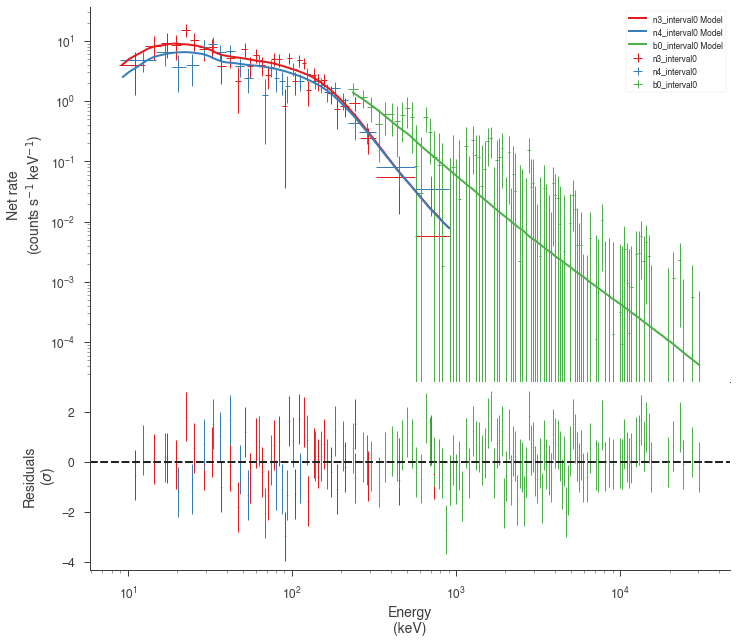

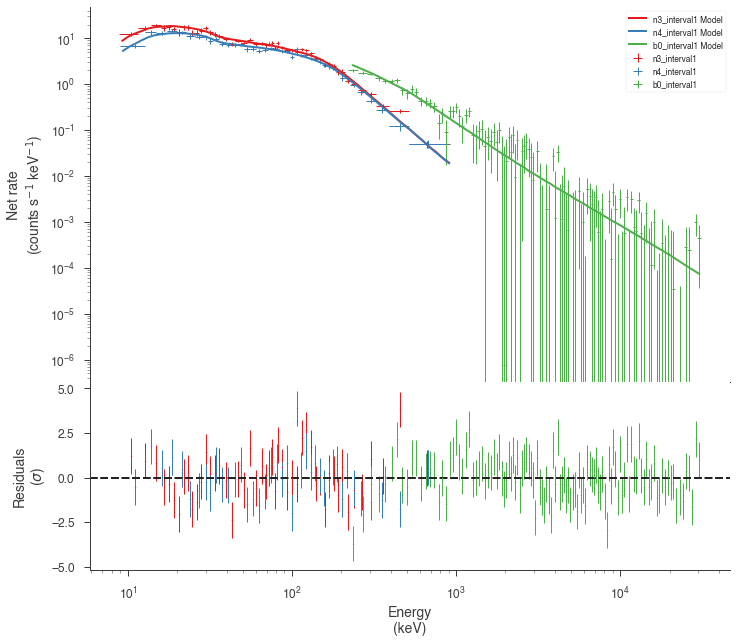

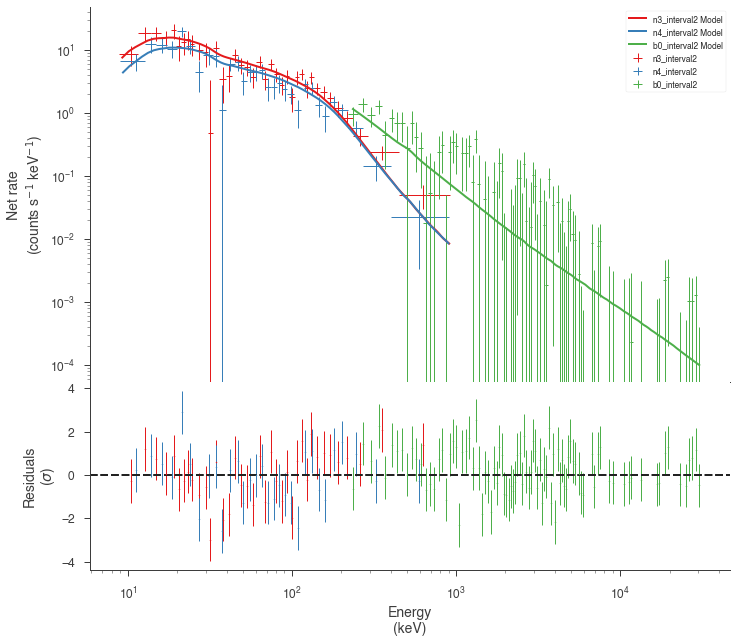

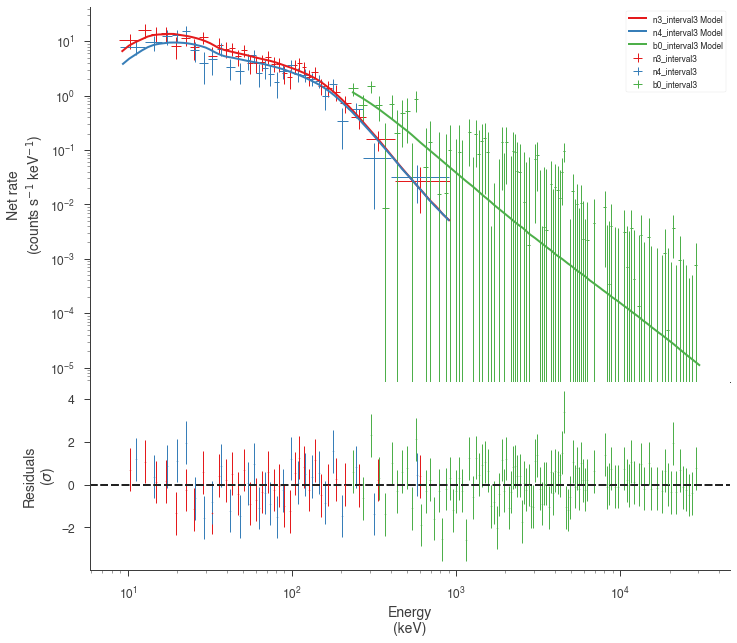

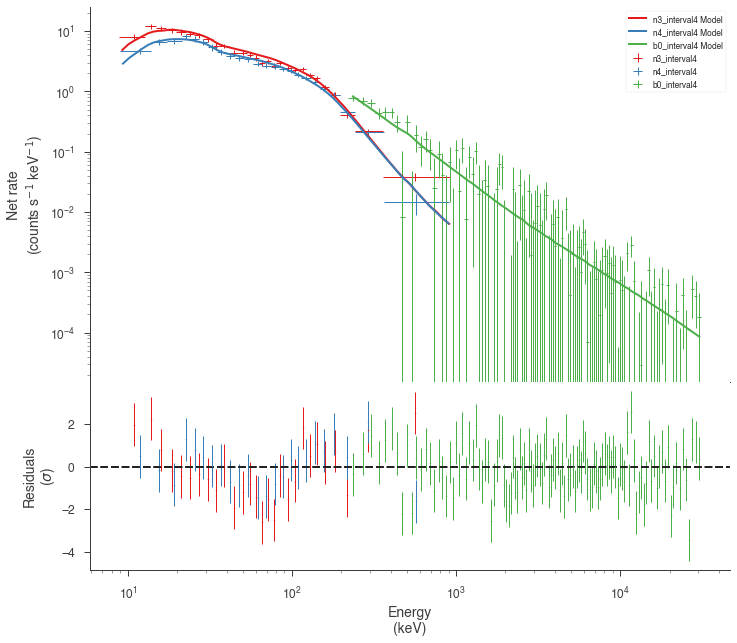

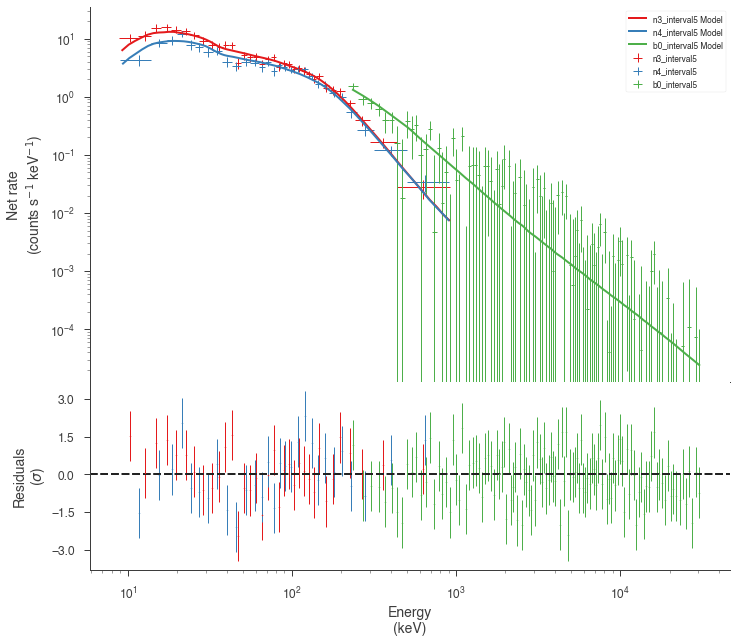

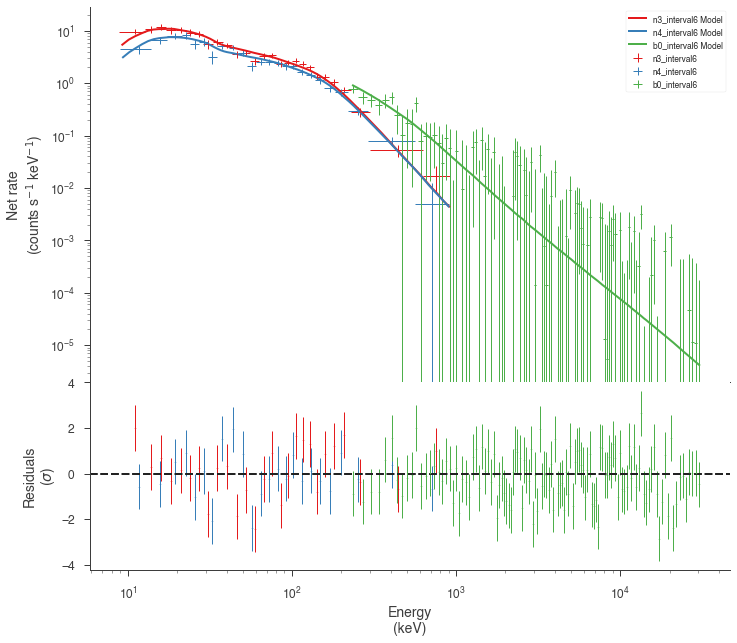

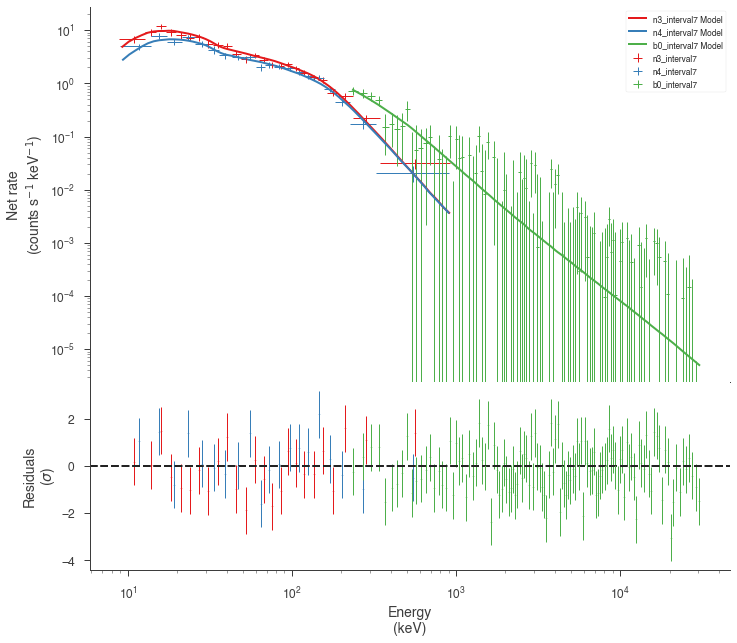

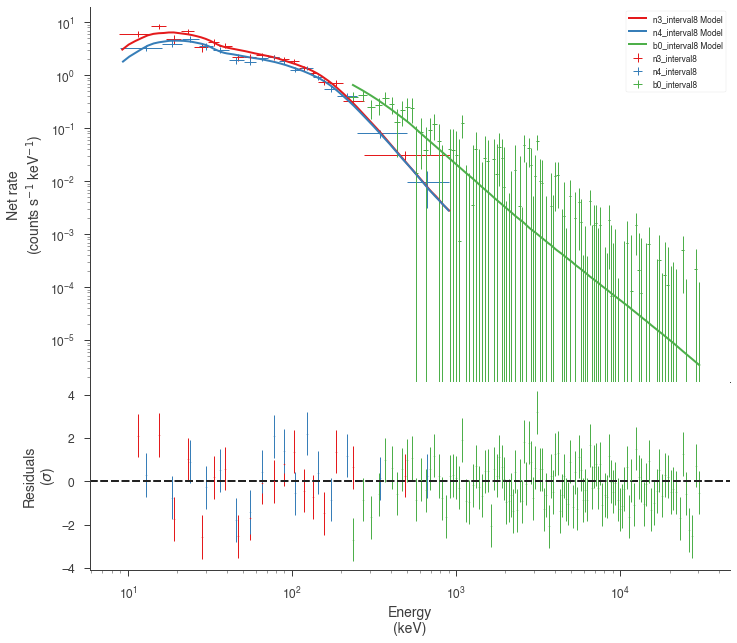

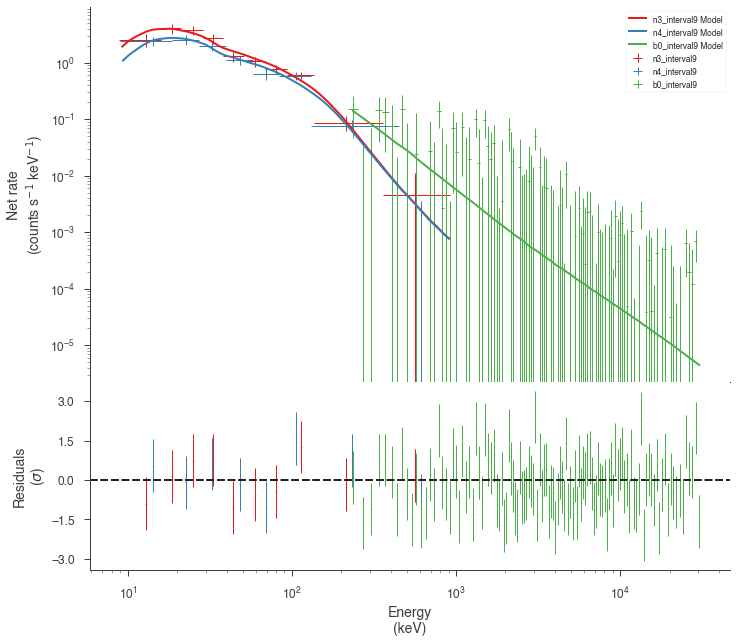

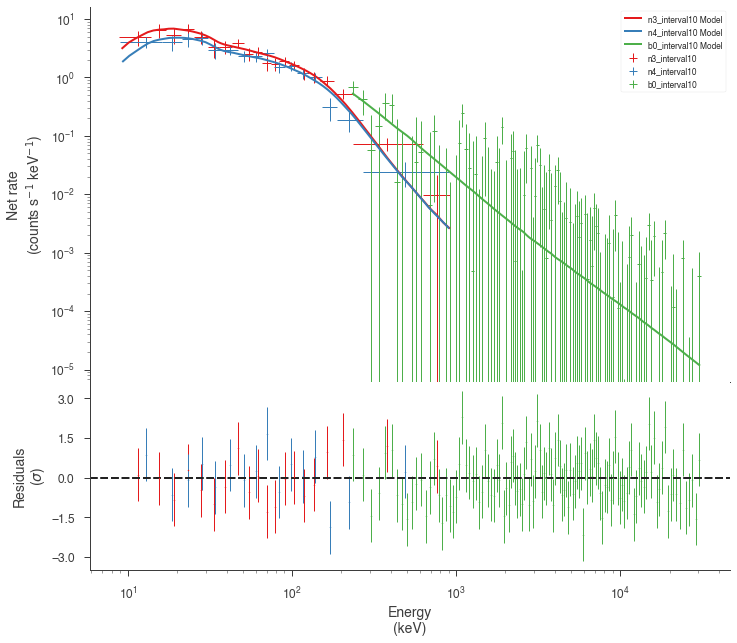

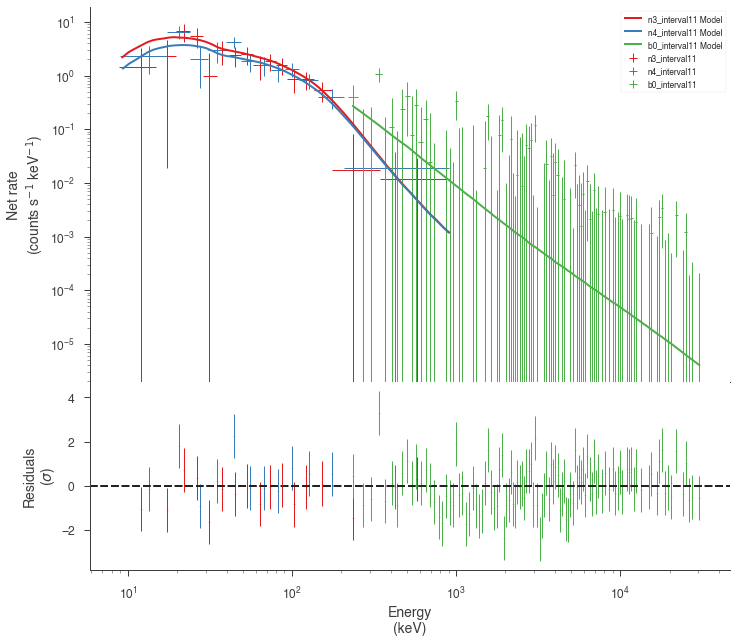

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, -99], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

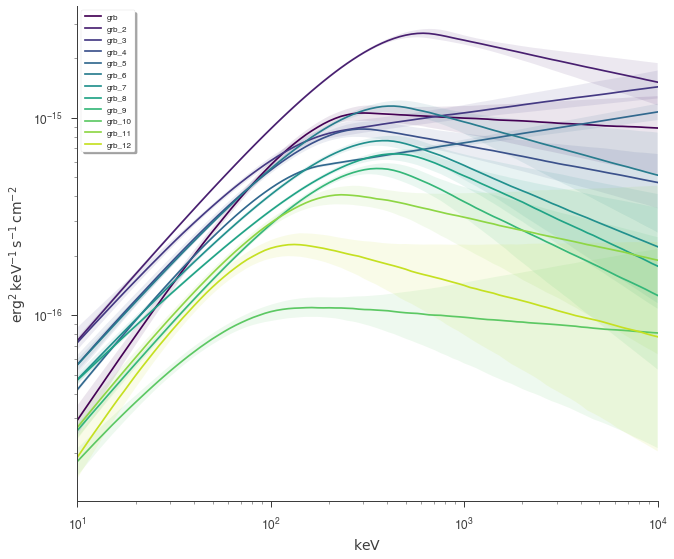

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.